<a href="https://colab.research.google.com/github/kclassie/ML_sundries/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D0%94%D0%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import heapq      #Модуль heapq в несколько раз облегчает написание программ, использующих такую 
#структуру данных как куча. Этот модуль обеспечивает реализацию алгоритма очереди с кучами, также известный как алгоритм очереди с приоритетами.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

# Задача классификации текстов

Задача классификации текстов заключается в том, чтобы определить по документу его класс.
В данном случае предлагается рассмотреть в качестве документов - письма, заранее отклассифицированных по 20 темам.

In [ ]:
all_categories = fetch_20newsgroups().target_names
all_categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Возьмём всего 3 темы, но из одного раздела (документы из близких тем сложнее отличать друг от друга)

In [ ]:
categories = [
    'sci.electronics',
    'sci.space',
    'sci.med'
]

train_data = fetch_20newsgroups(subset='train',
                                categories=categories,
                                remove=('headers', 'footers', 'quotes'))

test_data = fetch_20newsgroups(subset='test',
                               categories=categories,
                               remove=('headers', 'footers', 'quotes'))

## Векторизация текстов
**Вопрос: как описать текстовые документы пространством признаков?**


**Идея №1**: мешок слов (bag-of-words) - каждый документ или текст выглядит как неупорядоченный набор слов без сведений о связях между ними.
<img src='https://st2.depositphotos.com/2454953/9959/i/450/depositphotos_99593622-stock-photo-holidays-travel-bag-word-cloud.jpg'>

**Идея №2**: создаём вектор "слов", каждая компонента отвечает отдельному слову.

Для векторизации текстов воспользуемся [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Можно всячески варировать извлечение признаков (убирать редкие слова, убирать частые слова, убирать слова общей лексики, брать биграмы и т.д.)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
count_vectorizer = CountVectorizer(min_df=5, ngram_range=(1, 2)) 

In [ ]:
sparse_feature_matrix = count_vectorizer.fit_transform(train_data.data)
sparse_feature_matrix

<1778x10885 sparse matrix of type '<class 'numpy.int64'>'
	with 216486 stored elements in Compressed Sparse Row format>

In [ ]:
num_2_words = {
    v: k
    for k, v in count_vectorizer.vocabulary_.items()
}

Слова с наибольшим положительным весом, являются характерными словами темы

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

Воспользуемся `macro`-average для оценки качества решения в задаче многоклассовой классификации.

In [ ]:
f_scorer = make_scorer(f1_score, average='macro')

Обучим логистическую регрессию для предсказания темы документа

In [ ]:
algo = LogisticRegression(C=0.00001)
%time algo.fit(sparse_feature_matrix, train_data.target)

CPU times: user 82.4 ms, sys: 37.9 ms, total: 120 ms
Wall time: 76.3 ms


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
W = algo.coef_.shape[1]
for c in algo.classes_:
    topic_words = [
        num_2_words[w_num]
        for w_num in heapq.nlargest(10, range(W), key=lambda w: algo.coef_[c, w])
    ]
    print(',  '.join(topic_words))


wire,  ground,  wiring,  circuit,  use,  neutral,  power,  current,  voltage,  cable
of,  health,  medical,  in,  edu,  my,  patients,  and,  disease,  she
space,  nasa,  launch,  earth,  orbit,  satellite,  shuttle,  lunar,  moon,  on


Сравним качество на обучающей и отложенной выборках.

In [ ]:
%time algo.fit(sparse_feature_matrix, train_data.target)

CPU times: user 57.3 ms, sys: 48.3 ms, total: 106 ms
Wall time: 62.1 ms


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
f_scorer(algo, sparse_feature_matrix, train_data.target)

0.42392759632757676

In [ ]:
f_scorer(algo, count_vectorizer.transform(test_data.data), test_data.target)

0.38776774806066605

Значения f-меры получились очень низкие.
## <font color='red'> **Вопрос:** в чём причина низкоuо значения f-меры? </font>

Я думаю, что это связано в сбольшой плотностью входных данных. У нас много параметров, но не слишком много данных. Модель подгоняет значения к особенностям данных.

Нужно разрядить  массив - отобрать небольшое количество самых значимых данных, задающих тенденцию, и удалить все остальные, являющиеся просто шумом.

Другая возможная причина - регуляризация оказалась слишком сильной, и модель "недообучилась"

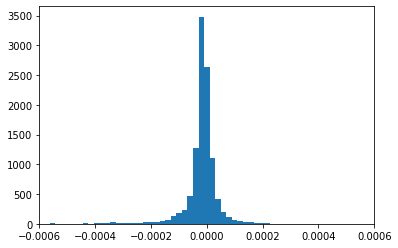

In [ ]:
plt.hist(algo.coef_[0], bins=500)
plt.xlim([-0.0006, 0.0006])
plt.show()

** Какую выбрать метрику для регуляризации? **

---



Нужно увеличить C. Тем самым мы ослабляем регуляризацию.
Пробовала несколько вариантов - С=0.1 и С=1. Второй лучше. Работает и с l2, и с l1

In [ ]:
algo = LogisticRegression(penalty='l1', C=1)
arr = cross_val_score(algo, sparse_feature_matrix, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.79231661 0.82645086 0.81185853 0.79768189 0.79703649]
0.8050688766254549


## <font color='red'> **Вопрос:** обосновать выбор метрики  </font>

Нужно увеличить C. Тем самым мы ослабляем регуляризацию. Пробовала несколько вариантов - С=0.1 и С=1. Второй лучше. Работает и с l2, и с l1

In [ ]:
algo.fit(sparse_feature_matrix, train_data.target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
f_scorer(algo, sparse_feature_matrix, train_data.target)

0.9659145669277202

In [ ]:
f_scorer(algo, count_vectorizer.transform(test_data.data), test_data.target)

0.7615239373164687

Подберём оптимальное значение параметра регуляризации

In [ ]:
def grid_plot(x, y, x_label, title, y_label='f_measure'):
    plt.figure(figsize=(12, 6))
    plt.grid(True),
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [ ]:
print(*map(float, np.logspace(-2, 2, 10)))

0.01 0.027825594022071243 0.0774263682681127 0.21544346900318834 0.5994842503189409 1.6681005372000592 4.6415888336127775 12.915496650148826 35.93813663804626 100.0


In [ ]:
lr_grid = {
    'C': np.logspace(-2, 2, 10),
}
gs = GridSearchCV(LogisticRegression(penalty='l1'), lr_grid, scoring=f_scorer, cv=5, n_jobs=5)
%time  gs.fit(sparse_feature_matrix, train_data.target)
print("best_params: {}, best_score: {}".format(gs.best_params_, gs.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 25.6 s, sys: 71.9 ms, total: 25.7 s
Wall time: 4min 15s
best_params: {'C': 12.915496650148826}, best_score: 0.8068760030456942


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Рассмотрим график:

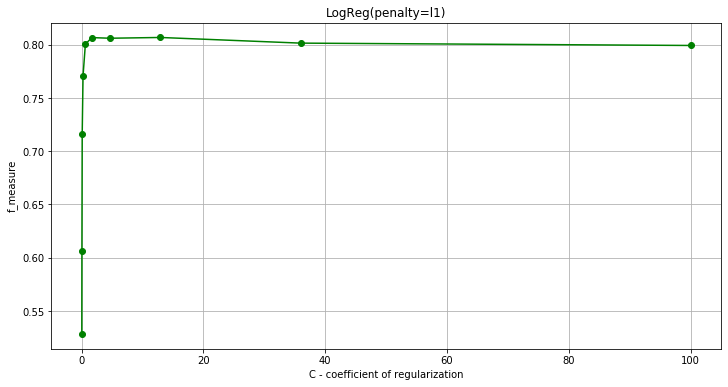

In [ ]:
grid_plot(
    lr_grid['C'], gs.cv_results_['mean_test_score'], 'C - coefficient of regularization', 'LogReg(penalty=l1)'
)

In [ ]:
lr_grid = {
    'C': np.linspace(1, 20, 40),
}
gs = GridSearchCV(LogisticRegression(penalty='l1'), lr_grid, scoring=f_scorer, cv=5, n_jobs=5)
%time  gs.fit(sparse_feature_matrix, train_data.target)
print("best_params: {}, best_score: {}".format(gs.best_params_, gs.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 21.9 s, sys: 138 ms, total: 22 s
Wall time: 33min 38s
best_params: {'C': 9.769230769230768}, best_score: 0.811404869209066


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


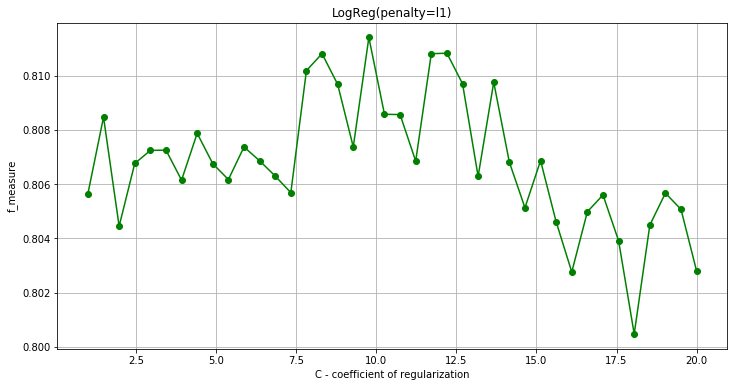

In [ ]:
grid_plot(
    lr_grid['C'], gs.cv_results_['mean_test_score'], 'C - coefficient of regularization', 'LogReg(penalty=l1)'
)

In [ ]:
lr_final = LogisticRegression(penalty='l1', C=10)
%time lr_final.fit(sparse_feature_matrix, train_data.target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 24.1 s, sys: 6.76 ms, total: 24.1 s
Wall time: 24.2 s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
accuracy_score(lr_final.predict(sparse_feature_matrix), train_data.target)

0.9808773903262092

In [ ]:
f_scorer(lr_final, sparse_feature_matrix, train_data.target)

0.9810071221526965

In [ ]:
accuracy_score(lr_final.predict(count_vectorizer.transform(test_data.data)), test_data.target)

0.7557058326289096

In [ ]:
f_scorer(lr_final, count_vectorizer.transform(test_data.data), test_data.target)

0.7555778876934628

## Регуляризация вместе с векторизацией признаков
Чтобы не делать векторизацию и обучение раздельно, есть удобный класс Pipeline. Он позволяет объединить в цепочку последовательность действий

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(min_df=5, ngram_range=(1, 2))),
    ("algo", LogisticRegression())
])

In [ ]:
pipeline.fit(train_data.data, train_data.target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('algo',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                   

In [ ]:
f_scorer(pipeline, train_data.data, train_data.target)

0.9804363797868283

In [ ]:
f_scorer(pipeline, test_data.data, test_data.target)

0.7930204194507636

## <font color='red'> **Вопрос:** обосновать улучшение результата</font>

Значения такие же как мы получали ранее, делая шаги раздельно.

In [ ]:
from sklearn.pipeline import make_pipeline

При кроссвалидации нужно, чтобы CountVectorizer не обучался на тесте (иначе объекты становятся зависимыми). Pipeline позволяет это просто сделать.

In [ ]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.83746513 0.84655975 0.82308768 0.83985549 0.83173934]
0.8357414775322148


В Pipeline можно добавлять новые шаги препроцессинга данных

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), TfidfTransformer(), LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.8711115  0.8703129  0.8482986  0.85701424 0.84020672]
0.8573887943863149


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
pipeline.fit(train_data.data, train_data.target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, voc...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
              

In [ ]:
accuracy_score(pipeline.predict(train_data.data), train_data.target)

0.96962879640045

In [ ]:
f_scorer(pipeline, train_data.data, train_data.target)

0.9697797455997105

In [ ]:
accuracy_score(pipeline.predict(test_data.data), test_data.target)

0.8241758241758241

In [ ]:
f_scorer(pipeline, test_data.data, test_data.target)

0.8250417787917681

Качество стало немного лучше

## <font color='red'> **Вопрос:** обосновать улучшение результата </font>

Мы использовали TfidfTransformer, чтобы преобразовать нашу числовую матрицу к представлению tf-idf - подсчитать, сколько раз слово встречается в корпусе. Это позволило снизить вес слов, которые появляются во многих документах в корпусе, и поэтому являются менее информативным, чем те, которые используются только в небольшой части корпуса.

 

# Классификация сообщений чатов

В качестве задания предлагается построить модель классификации текстов, соответствующих сообщениям из чатов по ML, Python и знакомствам.

**Данные** можно взять с <a src="https://www.kaggle.com/c/tfstextclassification">соревнования на Kaggle</a>, проведенное в рамках курса "Диалоговые системы" в Тинькофф. Прямая [ссылка](https://www.dropbox.com/s/8wckwzfy63ajxpm/tfstextclassification.zip?dl=0) на скачивание.

In [ ]:
data_path = 'data/{}'
df = pd.read_csv('train.csv', encoding='utf-8')

### Первичный анализ данных

In [ ]:
print(df.shape)

(112467, 3)


In [ ]:
df.head()

,id,text,label
0,0,ж 44 позн с мужч от 40 лет 0678935919,1
1,1,уже и не вспомню где это увидел,2
2,2,", sep=';', decimal=',' может изза этого",2
3,3,НУЖНА ДЕВ ДЛЯ С\\О -19л.0637048428смс,1
4,4,.М54.ИЩУ Д.Ж. С-П.ДЛЯ ЛАСК...НЕКМ.0508665030....,1


In [ ]:
label = 0
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  0 

OpenStack - это набор сервисов управления приватным облаком, там огромная кодовая база, пару десятков основных сервисов, управление сетями, object storage / file storage, куча всего.
----------------------------------------------------------------------------------------------------

а во, сразу сбросило на сайт демок аиохттп, спасибо
----------------------------------------------------------------------------------------------------

ну я работал на СИ и шарпах
----------------------------------------------------------------------------------------------------

а я пожалуй читать не буду пока
----------------------------------------------------------------------------------------------------

я тоже новичок, но я не платил за знания
----------------------------------------------------------------------------------------------------

Чёт я ему не верю, попробуй в таки в лист преобразовать
--------------------------------------------------------------------------------------

In [ ]:
label = 1
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  1 

М 35/83/90 пасс ищу м от 35 для неч. встречь Дн-жинск 0679967262 только СМС
----------------------------------------------------------------------------------------------------

я П 31 Хочу познакомиться с Дев или Жен для с/о звоните 0663976442
----------------------------------------------------------------------------------------------------

девченки два парня в сауне скучают 0999618325
----------------------------------------------------------------------------------------------------

П. 33 ВЫС. СТРОЙНЫЙ ПРИДЕТ К   Д.. С  ШАМПАНСКИМ 066 929 99 19
----------------------------------------------------------------------------------------------------

ищу:)до 30. Мне 22
----------------------------------------------------------------------------------------------------

М 44 ПОЗН.С ДЕВ..О.095.53.22.950
----------------------------------------------------------------------------------------------------

ПРИЕДУ К ДЕВУШКЕ  ЖЕНЩ НА НОЧЬ МНЕ32 0506998071 АЛЬКА УЧТИ
-------------

In [ ]:
label = 2
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  2 

Вспомнил древние времена, когда процессоры были ещё 286, а для совсем счастливчиков - 386, и получая компьютер на них себе в лабораторию, надо было проверять: а установлен ли сопроцессор? Ибо без него все наши расчеты тормозились знатно. \nПотом как-то забылись сопроцессоры, интегрировались прямо в CPU, но вот вновь, для новых потребностей. Выпущен USBшный модуль для ускорения задач, реализованных на нейронных сетках - Movidius Neural Compute Stick. Внутри - тот чип, который, например, обеспечивает качество машинного зрения в дронах DJI. \nНу что, для многих случаев вполне годная замена дорогой и прожорливой графической карте и заполнение ещё одной ниши на рынке устройств, заточенных под машинный интеллект.  \nhttps://www.theverge.com/2017/7/20/16002682/movidius-ai-neural-compute-stick-intel
----------------------------------------------------------------------------------------------------

Мортидо. Нажми на сообщение и тебя перекинет
--------------------------------------

### Разделим данные на train/test

In [ ]:
skf = StratifiedKFold(3, random_state=37)
train_index, test_index = next(skf.split(df.text, df.label))
train_df, test_df = df.iloc[train_index], df.iloc[test_index]
print(train_df.shape, test_df.shape)

(74977, 3) (37490, 3)


In [ ]:
train_df.head()

,id,text,label
37334,37334,.Молодой красивый спортивный парень ищет серьё...,1
37335,37335,вы озабоченые уточняю для даши было написано:)...,1
37336,37336,КАБАСЯ Я ТЕБЯ ЛЮБЛЮ И ОЧЕНЬ СКУЧАЮ...ТВОЯ ВИТА...,1
37337,37337,парень ищет парня для и\\о 093 783 37 87,1
37339,37339,РОЗСЛАБЛЮ В НОЧНОЕ ВРЕМЯ ПО ТЕЛЕФОНУ.ЦЕНА 10Г....,1


In [ ]:
test_df.head()

,id,text,label
0,0,ж 44 позн с мужч от 40 лет 0678935919,1
1,1,уже и не вспомню где это увидел,2
2,2,", sep=';', decimal=',' может изза этого",2
3,3,НУЖНА ДЕВ ДЛЯ С\\О -19л.0637048428смс,1
4,4,.М54.ИЩУ Д.Ж. С-П.ДЛЯ ЛАСК...НЕКМ.0508665030....,1


## Baseline

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from xgboost.sklearn import XGBClassifier

Преобразуем данные

In [ ]:
X_train = train_df.text
y_train = train_df.label
print(X_train.shape)

X_test = test_df.text
y_test = test_df.label
print(X_test.shape)

(74977,)
(37490,)


In [ ]:
X_train

37334     .Молодой красивый спортивный парень ищет серьё...
37335     вы озабоченые уточняю для даши было написано:)...
37336     КАБАСЯ Я ТЕБЯ ЛЮБЛЮ И ОЧЕНЬ СКУЧАЮ...ТВОЯ ВИТА...
37337             парень ищет парня  для и\\о 093 783 37 87
37339     РОЗСЛАБЛЮ В НОЧНОЕ ВРЕМЯ ПО ТЕЛЕФОНУ.ЦЕНА 10Г....
                                ...                        
112462    . Мужч. 45. Общение с женщиной. ВНАЧАЛЕ СМС  М...
112463                       чем не устраивает канал в ODS?
112464    ДОЦЯ ОЧЕНЬ РЕСКА ПАВАРАЧЕВАТЬ НЕЛЬЗЯ. БУДЬ ЧЮТ...
112465    Привет наш любимый дорогой сыночек.Очень скуча...
112466    ? сегодня услышал kmean от гуманитария на рабо...
Name: text, Length: 74977, dtype: object

## <font color='red'> Задание: применить TF-IDF для кодирования текстовой информациии и затем обучить модель</font>
будьте внимательны, что к валидационной части данных также необходимо применить эту процедуру

Также можно использовать другие методы кодированния текстов и затем сравнить полученные результаты

Подготовим pipeline

In [ ]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("clf", DecisionTreeClassifier()),
])

In [ ]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), TfidfTransformer(), LogisticRegression())
arr = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.80643936 0.80584322 0.8095673  0.81094617 0.80607048]
0.8077733053221943


In [ ]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, voc...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
              

In [ ]:
accuracy_score(pipeline.predict(X_train), y_train)

0.9005428331354949

In [ ]:
f_scorer(pipeline, X_train, y_train)

0.8664190423011421

In [ ]:
accuracy_score(pipeline.predict(X_test), y_test)

0.8639903974393172

In [ ]:
f_scorer(pipeline, X_test, y_test)

0.8146823301106126

###  <font color='red'> Задание: Протестировать различные параметры CountVectorizer()</font>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


Обучим классификатор

In [ ]:
%%time
clf = pipeline
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 5.32 s, sys: 1.2 s, total: 6.53 s
Wall time: 5.15 s


Оценим качество

In [ ]:
print("Train_acc: {:.4f}, train_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_train), y_train),
    f_scorer(clf, X_train, y_train)
))

Train_acc: 0.9005, train_f-measure: 0.8664


In [ ]:
print("Test_acc: {:.4f}, test_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_test), y_test),
    f_scorer(clf, X_test, y_test)
))

Test_acc: 0.8640, test_f-measure: 0.8147


## <font color='red'> Задание: улучшить результат и сделать вывод о влиянии использованных методов на итоговый результат

### Your turn

Как видим, наша модель переобучилась. Для получения лучших результатов попробуйте воспользоваться более хитрыми и походящими инструментами.

1. Попробуйте поработать с параметрами `CountVectorizer`.
2. Попробуйте воспользоваться TF-IDF для кодирования текстовой информации ([ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).
3. Попробуйте воспользоваться другими моделями и средствами снижения размерности.

Формальный критерий успешности выполнения данного задания: 
* Проведен честный эксперимент с апробацией различных методов (>=3)
* Полученный алгоритм не выказывает явных следов переобучения (качество на train и test не различаются более, чем на 0.03 условных попугая)
* Test accuracy >= 0.835, f1-score >= 0.815

**0.5 extra points**

При частичном выполнении данного задания можно получить неполный балл. Качественный эксперимент, не побивший пороговые значения оценивается неполным баллом на усмотрение преподавателя. При получении пороговых score'ов случайным образом (без анализа) бонус не засчитывается. 

# Эксперимент №1
изменим параметры CountVectorizer: увеличим min_df, чтобы игнорировать термины, у которых частота ниже заданного порога. Увеличим размерность n-грамм, чтобы включались триграммы

In [ ]:
pipeline = make_pipeline(CountVectorizer(min_df=10, ngram_range=(1, 3)), TfidfTransformer(), LogisticRegression())
arr = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.80240347 0.80171182 0.80697583 0.80506208 0.80226412]
0.8036834624953016


In [ ]:
clf = pipeline
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
              

In [ ]:
print("Train_acc: {:.4f}, train_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_train), y_train),
    f_scorer(clf, X_train, y_train)
))

Train_acc: 0.8897, train_f-measure: 0.8515


In [ ]:
print("Test_acc: {:.4f}, test_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_test), y_test),
    f_scorer(clf, X_test, y_test)
))

Test_acc: 0.8607, test_f-measure: 0.8113


# Вывод
Стало получше

# Эксперимент №2
изменим параметры CountVectorizer: изменим параметр n-грамм, чтобы включались только триграммы

In [ ]:
pipeline = make_pipeline(CountVectorizer(min_df=10, ngram_range=(3, 3)), TfidfTransformer(), LogisticRegression())
arr = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.29574087 0.28942589 0.29001421 0.28448777 0.3801589 ]
0.30796552957188805


In [ ]:
clf = pipeline
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(3, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
              

In [ ]:
print("Train_acc: {:.4f}, train_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_train), y_train),
    f_scorer(clf, X_train, y_train)
))

Train_acc: 0.5203, train_f-measure: 0.4096


In [ ]:
print("Test_acc: {:.4f}, test_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_test), y_test),
    f_scorer(clf, X_test, y_test)
))

Test_acc: 0.5119, test_f-measure: 0.3998


# Вывод
Что-то не очень

# Эксперимент №3
к параметрам Эксперимента №1 добавим регуляризацию лоистической регрессии

In [ ]:
pipeline = make_pipeline(CountVectorizer(min_df=10, ngram_range=(1, 3)), TfidfTransformer(), LogisticRegression(penalty='l1', C=12))
arr = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.80343287 0.80603698 0.80302072 0.80522972 0.802622  ]
0.8040684559746494


In [ ]:
clf = pipeline
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...
                ('tfidftransformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('logisticregression',
                 LogisticRegression(C=12, class_weight=None, dual=False,
                                    fit_intercept=True,

In [ ]:
print("Train_acc: {:.4f}, train_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_train), y_train),
    f_scorer(clf, X_train, y_train)
))

Train_acc: 0.9272, train_f-measure: 0.9043


In [ ]:
print("Test_acc: {:.4f}, test_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_test), y_test),
    f_scorer(clf, X_test, y_test)
))

Test_acc: 0.8522, test_f-measure: 0.8102


#Вывод
Тоже не очень. Попробуем найти лучшие параметры регуляризации, как делали выше

In [ ]:
sparse_feature_matrix2 = count_vectorizer.fit_transform(X_train)
sparse_feature_matrix2

<74977x28245 sparse matrix of type '<class 'numpy.int64'>'
	with 845996 stored elements in Compressed Sparse Row format>

In [ ]:
lr_grid = {
    'C': np.logspace(-2, 2, 10),
}
gs = GridSearchCV(LogisticRegression(penalty='l1'), lr_grid, scoring=f_scorer, cv=5, n_jobs=5)
%time  gs.fit(sparse_feature_matrix2, y_train)
print("best_params: {}, best_score: {}".format(gs.best_params_, gs.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 1.95 s, sys: 226 ms, total: 2.17 s
Wall time: 25min 6s
best_params: {'C': 1.6681005372000592}, best_score: 0.8178078239725848


#Эксперимент №4
Испробуем получившийся параметр

In [ ]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), TfidfTransformer(), LogisticRegression(penalty='l1', C=1.6))
arr = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.80863047 0.80652408 0.81055712 0.81417329 0.81207844]
0.8103926802124107


In [ ]:
clf = pipeline
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, voc...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('logisticregression',
                 LogisticRegression(C=1.6, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
              

In [ ]:
print("Train_acc: {:.4f}, train_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_train), y_train),
    f_scorer(clf, X_train, y_train)
))

Train_acc: 0.9029, train_f-measure: 0.8719


In [ ]:
print("Test_acc: {:.4f}, test_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_test), y_test),
    f_scorer(clf, X_test, y_test)
))

Test_acc: 0.8622, test_f-measure: 0.8172
